# Gradient-Descent optimization
There are methods to optimize the gradient descent.
Use the same example as the one in gradient descent.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import os
#os.environ['OMP_NUM_THREADS'] = '1'
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# define 2D function 
def func(x, y,noise=False,iteration=None):
    # main part   multi-local extrema
    main_func = (torch.sin(0.5 * x) * torch.cos(0.3 * y) +
                 torch.sin(0.2 * x * y) +
                 0.1 * (x ** 2 + y ** 2) +
                 2 * torch.sin(x + 0.5 * y))
    # add noise to simulate SGD
    if noise:
        noise_level = 0.5  # basic noise
        if iteration is not None:
            noise_level *= (1 + 0.3 * torch.sin(torch.tensor(iteration / 3.0)))
        return main_func + noise_level * torch.randn(1) * 2
    return main_func

In [3]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)


# Opti param
learning_rate = 0.4
iterations = 50
sample_size = 10  # 每次迭代评估的样本点数
batch_size = 100

## MBGD with no Optimization


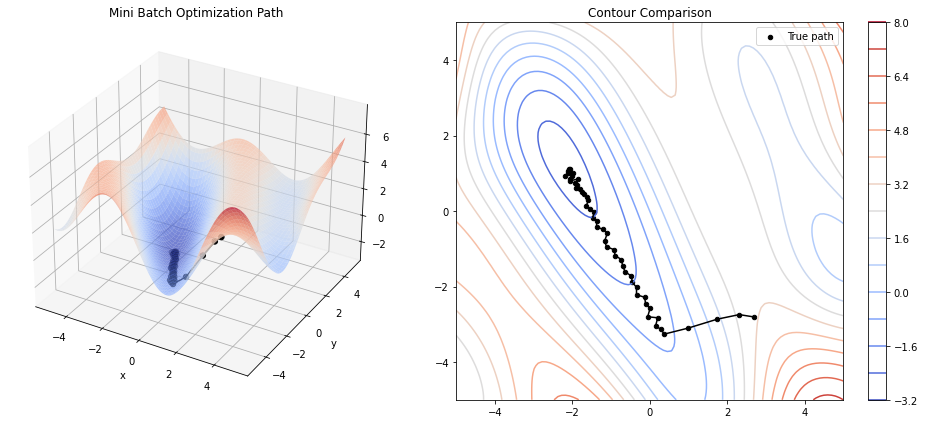


Final result:
x = -2.0900, y = 1.1261
Minimum value f(x,y) = -2.7040


In [5]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)

# process storage
history = []
batch_history = []  

# MBGD
for i in range(iterations):
    # clear
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()

    grad_x = 0
    grad_y = 0

    # mini-batch
    for _ in range(batch_size):
        noisy_x = x + torch.randn(1) * 0.5
        noisy_y = y + torch.randn(1) * 0.5

        z = func(noisy_x, noisy_y, True, i)

        z.backward()

        grad_x += x.grad.item()
        grad_y += y.grad.item()

        batch_history.append([noisy_x.item(), noisy_y.item(), z.item()])

        # clear
        x.grad.zero_()
        y.grad.zero_()
    # calc mean
    avg_grad_x = grad_x / batch_size
    avg_grad_y = grad_y / batch_size

    # Update
    with torch.no_grad():
        x -= learning_rate * avg_grad_x
        y -= learning_rate * avg_grad_y

        # record true
        true_z = func(x, y, False)
        history.append([x.item(), y.item(), true_z.item()])


# visulization
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5 , 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

history = np.array(history)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.scatter(history[:, 0], history[:, 1], history[:, 2], c='black', s=30)
ax1.plot(history[:, 0], history[:, 1], history[:, 2], 'k-', lw=1.5)
ax1.set_title('Mini Batch Optimization Path')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.scatter(history[:, 0], history[:, 1], c='black', s=20, label='True path')
ax3.plot(history[:, 0], history[:, 1], 'k-', lw=1.5)
ax3.set_title('Contour Comparison')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# output
print(f"\nFinal result:")
print(f"x = {x.item():.4f}, y = {y.item():.4f}")
print(f"Minimum value f(x,y) = {func(x, y).item():.4f}")


## MBGD with Momentum
### Momentum
- Analogy with physical momentum
- Keep taking into account past gradients but let their contribution decay exponentially with time
- This is performed through a **velocity** parameter which accumulates the value of previous gradients
- This dampens oscillations, yielding a more robust gradients which in turn leads to faster convergence

#### Steps:
- Learning rate $\gamma$, momentum parameter $\alpha$
- Initial parameter $w$, initial velocity $v$
- Loop the epoch
    - Compute gradient
$$
\bigtriangledown G(w)=\frac{1}{m}\sum_{i=1}^m \bigtriangledown L(w;x_i,y_i) 
$$
    - Compute velocity update
$$
v=\alpha v-\gamma \bigtriangledown G(w)
$$
    - Apply update $w = w+v$
- End loop

#### empirical value
Typical values are 0.5, 0.9, or 0.99.
Usually it starts at a low value that is then raised with time

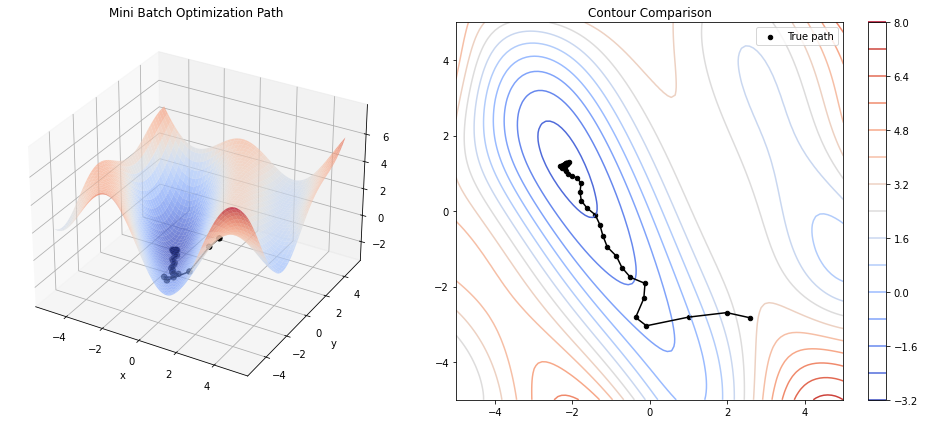


Final result:
x = -2.1849, y = 1.2464
Minimum value f(x,y) = -2.7117


In [21]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)

a=0.5
v_x=0
v_y=0

# process storage
history = []
batch_history = []  

# MBGD
for i in range(iterations):
    # clear
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()

    grad_x = 0
    grad_y = 0

    # mini-batch
    for _ in range(batch_size):
        noisy_x = x + torch.randn(1) * 0.5
        noisy_y = y + torch.randn(1) * 0.5

        z = func(noisy_x, noisy_y, True, i)

        z.backward()

        grad_x += x.grad.item()
        grad_y += y.grad.item()

        batch_history.append([noisy_x.item(), noisy_y.item(), z.item()])

        # clear
        x.grad.zero_()
        y.grad.zero_()
    # calc mean
    avg_grad_x = grad_x / batch_size
    avg_grad_y = grad_y / batch_size

    # Update
    with torch.no_grad():
        #x -= learning_rate * avg_grad_x
        #y -= learning_rate * avg_grad_y
        v_x=a*v_x-learning_rate*avg_grad_x
        v_y=a*v_y-learning_rate*avg_grad_y
        
        x+=v_x
        y+=v_y

        # record true
        true_z = func(x, y, False)
        history.append([x.item(), y.item(), true_z.item()])


# visulization
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5 , 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

history = np.array(history)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.scatter(history[:, 0], history[:, 1], history[:, 2], c='black', s=30)
ax1.plot(history[:, 0], history[:, 1], history[:, 2], 'k-', lw=1.5)
ax1.set_title('Mini Batch Optimization Path')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.scatter(history[:, 0], history[:, 1], c='black', s=20, label='True path')
ax3.plot(history[:, 0], history[:, 1], 'k-', lw=1.5)
ax3.set_title('Contour Comparison')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# output
print(f"\nFinal result:")
print(f"x = {x.item():.4f}, y = {y.item():.4f}")
print(f"Minimum value f(x,y) = {func(x, y).item():.4f}")


### Nesterov momentum
Just like standard momentum, but use the future gradient (which results in better convergence)
#### Steps:
- Learning rate $\gamma$, momentum parameter $\alpha$
- Initial parameter $w$, initial velocity $v$
- Loop the epoch
    - Apply interim update:$\tilde{w}=w+\alpha v$
    - Compute gradient
$$
\bigtriangledown G(\tilde{w})=\frac{1}{m}\sum_{i=1}^m \bigtriangledown L(\tilde{w};x_i,y_i) 
$$
    - Compute velocity update
$$
v=\alpha v-\gamma \bigtriangledown G(w)
$$
    - Apply update $w = w+v$
- End loop

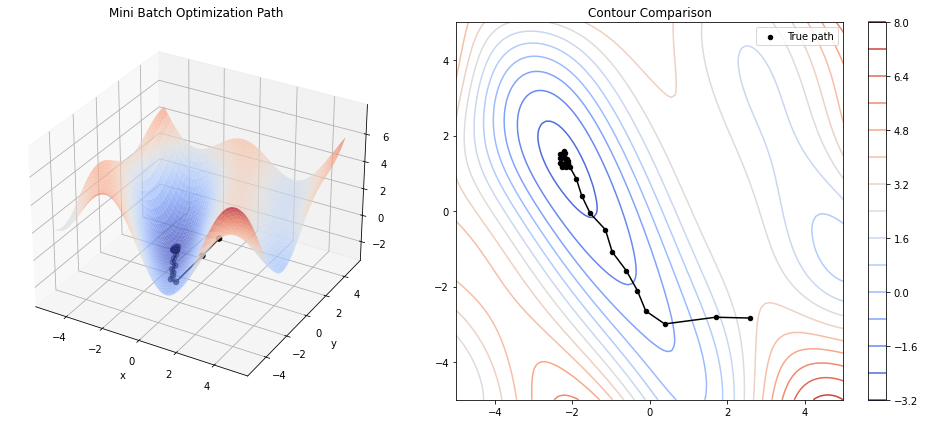


Final result:
x = -2.1529, y = 1.2103
Minimum value f(x,y) = -2.7102


In [23]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)

a=0.75
v_x=0
v_y=0

# process storage
history = []
batch_history = []  

# MBGD
for i in range(iterations):
    # clear
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()

    grad_x = 0
    grad_y = 0

    # mini-batch
    for _ in range(batch_size):
        
        noisy_x = x + torch.randn(1) * 0.5+a*v_x
        noisy_y = y + torch.randn(1) * 0.5+a*v_y    

        z = func(noisy_x, noisy_y, True, i)      

        z.backward()

        grad_x = grad_x+ x.grad.item()
        grad_y = grad_y+ y.grad.item()

        batch_history.append([noisy_x.item(), noisy_y.item(), z.item()])

        # clear
        x.grad.zero_()
        y.grad.zero_()
    # calc mean
    avg_grad_x = grad_x / batch_size
    avg_grad_y = grad_y / batch_size

    # Update
    with torch.no_grad():
        #x -= learning_rate * avg_grad_x
        #y -= learning_rate * avg_grad_y
        v_x=a*v_x-learning_rate*avg_grad_x
        v_y=a*v_y-learning_rate*avg_grad_y
        
        x+=v_x
        y+=v_y

        # record true
        true_z = func(x, y, False)
        history.append([x.item(), y.item(), true_z.item()])


# visulization
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5 , 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

history = np.array(history)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.scatter(history[:, 0], history[:, 1], history[:, 2], c='black', s=30)
ax1.plot(history[:, 0], history[:, 1], history[:, 2], 'k-', lw=1.5)
ax1.set_title('Mini Batch Optimization Path')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.scatter(history[:, 0], history[:, 1], c='black', s=20, label='True path')
ax3.plot(history[:, 0], history[:, 1], 'k-', lw=1.5)
ax3.set_title('Contour Comparison')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# output
print(f"\nFinal result:")
print(f"x = {x.item():.4f}, y = {y.item():.4f}")
print(f"Minimum value f(x,y) = {func(x, y).item():.4f}")


## MBGD with Adaptive learning rates
- Learning rate hard to set as it significantly affects the model performance
    - Loss function can change in very different ways in different directions
    - Momentum helps, but it’s yet another hyper parameter
- We can try to learn individual learning rates for each parameter and automatically adapt them


### Delta-bar-delta
- One the first heuristics (1988) to adapt individual learning rates during training
- If the sign of the partial derivative of the loss with respect to a given model parameter remains the same, then the learning rate should increase
- If it changes, the learning rate should decrease
- Works only with batch gradient descent

### AdaGrad
- Adapt learning rates of model parameters by scaling them inversely proportional to the square root of the sum of all the past squared values of the gradient
- Learning rate of parameters with large (small) value of partial derivative of loss decreases (increases)
    - Faster progress in gently sloped directions
- But long history of gradients can slow things down

#### Steps:
- Learning rate $\gamma$
- Initial parameter $w$
- Small constant $\delta$,perhaps $10^{-7}$, for numerical stability
- Initial gradient accumulation variable $v=0$
- Loop the epoch
    - Compute gradient
$$
G(w)=\frac{1}{m}\sum_{i=1}^m \bigtriangledown L(w;x_i,y_i) 
$$
    - Accumulate squared gradient: $v=v+G \odot G$
    - Compute update:$\bigtriangleup w = \frac{\gamma}{\delta + \sqrt{v}} \odot G$
    - Apply update $w = w+\bigtriangleup w$


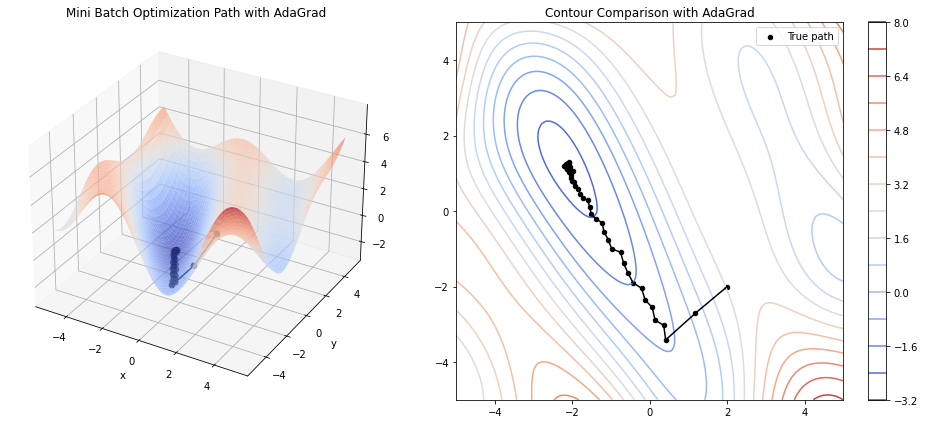


Final result with:
x = -2.1445, y = 1.2607
Minimum value f(x,y) = -2.7089


In [5]:
learning_rate=1.0
v_x = 0
v_y = 0

# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)

# AdaGrad参数
delta = 1e-8  # 防止除零的小常数
sum_grad_x_sq = 0
sum_grad_y_sq = 0

# process storage
history = []
batch_history = []  

# MBGD with AdaGrad
for i in range(iterations):
    # clear gradients
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()

    grad_x = 0
    grad_y = 0

    # mini-batch
    for _ in range(batch_size):
        noisy_x = x + torch.randn(1) * 0.5
        noisy_y = y + torch.randn(1) * 0.5

        z = func(noisy_x, noisy_y, True, i)

        z.backward()

        grad_x += x.grad.item()
        grad_y += y.grad.item()

        batch_history.append([noisy_x.item(), noisy_y.item(), z.item()])

        # clear gradients
        x.grad.zero_()
        y.grad.zero_()
    
    # calc mean gradients
    avg_grad_x = grad_x / batch_size
    avg_grad_y = grad_y / batch_size
    
    # AdaGrad: 累积梯度平方和
    sum_grad_x_sq += avg_grad_x ** 2
    sum_grad_y_sq += avg_grad_y ** 2
    
    # AdaGrad: 计算自适应学习率
    adaptive_lr_x = learning_rate / (torch.sqrt(torch.tensor(sum_grad_x_sq)) + delta)
    adaptive_lr_y = learning_rate / (torch.sqrt(torch.tensor(sum_grad_y_sq)) + delta)

    # Update parameters with AdaGrad
    with torch.no_grad():
        x -= adaptive_lr_x * avg_grad_x
        y -= adaptive_lr_y * avg_grad_y
        
        # record true position and value
        true_z = func(x, y, False)
        history.append([x.item(), y.item(), true_z.item()])


# 可视化部分保持不变
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5 , 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

history = np.array(history)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.scatter(history[:, 0], history[:, 1], history[:, 2], c='black', s=30)
ax1.plot(history[:, 0], history[:, 1], history[:, 2], 'k-', lw=1.5)
ax1.set_title('Mini Batch Optimization Path with AdaGrad')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.scatter(history[:, 0], history[:, 1], c='black', s=20, label='True path')
ax3.plot(history[:, 0], history[:, 1], 'k-', lw=1.5)
ax3.set_title('Contour Comparison with AdaGrad')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# output
print(f"\nFinal result with:")
print(f"x = {x.item():.4f}, y = {y.item():.4f}")
print(f"Minimum value f(x,y) = {func(x, y).item():.4f}")

learning_rate=0.4

### RMSprop
- RMSprop is an (unpublished) modification of AdaGrad that accumulates past gradients using an exponential moving average
- While AdaGrad is designed to work well for convex functions, RMSprop works better in non-convex settings (typical of deep learning)

#### Steps:
- Learning rate $\gamma$,decay rate $\rho$
- Initial parameter $w$
- Small constant $\delta$,perhaps $10^{-7}$, for numerical stability
- Initial gradient accumulation variable $v=0$
- Loop the epoch
    - Compute gradient
$$
G(w)=\frac{1}{m}\sum_{i=1}^m \bigtriangledown L(w;x_i,y_i) 
$$
    - Accumulate squared gradient: $v=\rho v+(1-\rho)G \odot G$
    - Compute update:$\bigtriangleup w = \frac{\gamma}{\delta + \sqrt{v}} \odot G$
    - Apply update $w = w+\bigtriangleup w$


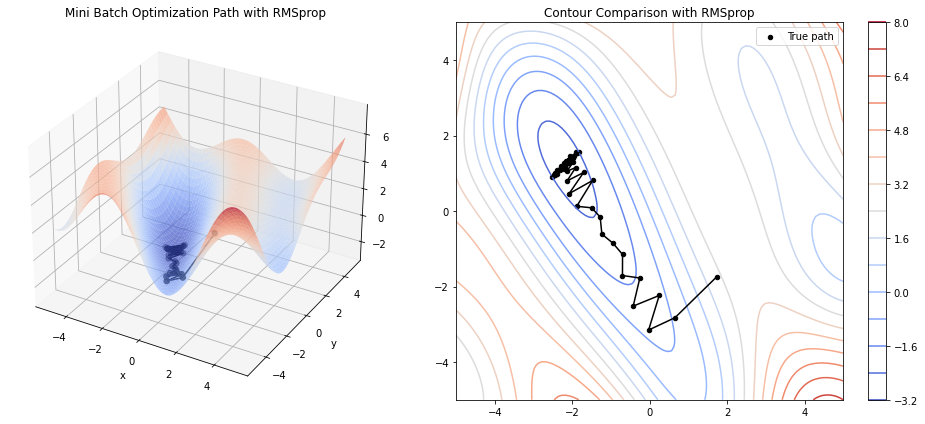


Final result with:
x = -2.1977, y = 1.1778
Minimum value f(x,y) = -2.7074


In [14]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)

# params
learning_rate=0.4
delta = 1e-8  # 防止除零的小常数
ro=0.9
v_x=0
v_y=0

# process storage
history = []
batch_history = []  

# MBGD with RMSprop
for i in range(iterations):
    # clear gradients
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()

    grad_x = 0
    grad_y = 0

    # mini-batch
    for _ in range(batch_size):
        noisy_x = x + torch.randn(1) * 0.5
        noisy_y = y + torch.randn(1) * 0.5

        z = func(noisy_x, noisy_y, True, i)

        z.backward()

        grad_x += x.grad.item()
        grad_y += y.grad.item()

        batch_history.append([noisy_x.item(), noisy_y.item(), z.item()])

        # clear gradients
        x.grad.zero_()
        y.grad.zero_()
    
    # calc mean gradients
    avg_grad_x = grad_x / batch_size
    avg_grad_y = grad_y / batch_size

    # RMSprop
    v_x = ro*v_x + (1-ro)*avg_grad_x ** 2
    v_y = ro*v_y + (1-ro)*avg_grad_y ** 2
    
    # RMSprop update
    d_x = learning_rate*avg_grad_x / (torch.sqrt(torch.tensor(v_x)) + delta)
    d_y = learning_rate*avg_grad_y / (torch.sqrt(torch.tensor(v_y)) + delta)
  
    # Update parameters with Adam
    with torch.no_grad():
        x -= d_x
        y -= d_y
        
        # record true position and value
        true_z = func(x, y, False)
        history.append([x.item(), y.item(), true_z.item()])


# visualization
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5 , 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

history = np.array(history)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.scatter(history[:, 0], history[:, 1], history[:, 2], c='black', s=30)
ax1.plot(history[:, 0], history[:, 1], history[:, 2], 'k-', lw=1.5)
ax1.set_title('Mini Batch Optimization Path with RMSprop')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.scatter(history[:, 0], history[:, 1], c='black', s=20, label='True path')
ax3.plot(history[:, 0], history[:, 1], 'k-', lw=1.5)
ax3.set_title('Contour Comparison with RMSprop')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# output
print(f"\nFinal result with:")
print(f"x = {x.item():.4f}, y = {y.item():.4f}")
print(f"Minimum value f(x,y) = {func(x, y).item():.4f}")

### Adam
- Best understood as a way of combining RMSprop with SGD + momentum
- Uses square gradients to scale learning rate like RMSprop + moving average of gradient for momentum
- Turns out to be fairly robust to choice of hyperparameters


#### Steps:
- Step size $\epsilon$ (Suggested default:0.001)
- Learning rate $\gamma$,
- Exponential decay rates for moment estimates, $\rho_1$ and $\rho_2$ in $[0,1)$(Suggested default:0.9 and 0.999 respectively) 
- Initial parameter $w$
- Initial 1st and 2nd moment variables $a=0$,$b=0$
- Small constant $\delta$,perhaps $10^{-8}$, for numerical stability
- Initial time step $t=0$
- Loop the epoch
    - Compute gradient
$$
G(w)=\frac{1}{m}\sum_{i=1}^m \bigtriangledown L(w;x_i,y_i) 
$$
    - $t=t+1$
    - Update biased first moment estimate: $a=\rho_1 a+(1-\rho_1)G $
    - Update biased second moment estimate: $b=\rho_1 b+(1-\rho_1)G \odot G$
    - Correct bias in first moment:$\hat{a}=\frac{a}{1-\rho_1^t}$
    - Correct bias in first moment:$\hat{b}=\frac{b}{1-\rho_2^t}$
    - Compute update:$\bigtriangleup w = -\epsilon \frac{\hat{a}}{\delta + \sqrt{\hat{b}}} \odot G$
    - Apply update $w = w+\bigtriangleup w$

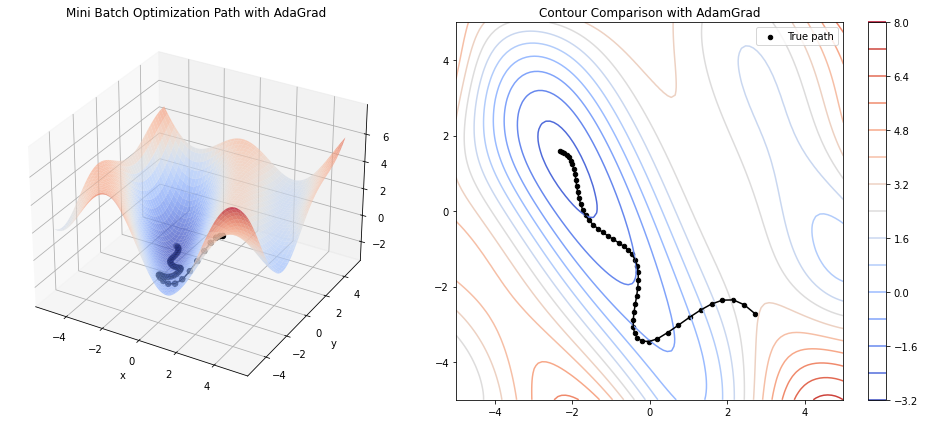


Final result with:
x = -2.3252, y = 1.5804
Minimum value f(x,y) = -2.6954


In [11]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)

# Adam参数
delta = 1e-8  # 防止除零的小常数
epsilon=0.28
ro1=0.9
ro2=0.999
ax=0.0
ay=0.0
bx=0.0
by=0.0
t=0

# process storage
history = []
batch_history = []  

# MBGD with Adam
for i in range(iterations):
    # clear gradients
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()

    grad_x = 0
    grad_y = 0

    # mini-batch
    for _ in range(batch_size):
        noisy_x = x + torch.randn(1) * 0.5
        noisy_y = y + torch.randn(1) * 0.5

        z = func(noisy_x, noisy_y, True, i)

        z.backward()

        grad_x += x.grad.item()
        grad_y += y.grad.item()

        batch_history.append([noisy_x.item(), noisy_y.item(), z.item()])

        # clear gradients
        x.grad.zero_()
        y.grad.zero_()
    
    # calc mean gradients
    avg_grad_x = grad_x / batch_size
    avg_grad_y = grad_y / batch_size
    
    # time step update
    t+=1;
    
    # update biased moment estimate
    ax = ro1*ax+(1-ro1)*avg_grad_x
    ay = ro1*ay+(1-ro1)*avg_grad_y
    
    bx = ro2*bx+(1-ro2)*avg_grad_x**2
    by = ro2*by+(1-ro2)*avg_grad_y**2
    
    # Correct bias moment
    ax_hat = ax/(1-ro1**t)
    ay_hat = ay/(1-ro1**t)
    
    bx_hat = bx/(1-ro2**t)
    by_hat = by/(1-ro2**t)
    
    #
    dx = -epsilon*ax_hat / (torch.sqrt(torch.tensor(bx_hat)) + delta)
    dy = -epsilon*ay_hat / (torch.sqrt(torch.tensor(by_hat)) + delta)

    
    # Update parameters with Adam
    with torch.no_grad():
        x += dx
        y += dy
        
        # record true position and value
        true_z = func(x, y, False)
        history.append([x.item(), y.item(), true_z.item()])


# visualization
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5 , 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

history = np.array(history)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.scatter(history[:, 0], history[:, 1], history[:, 2], c='black', s=30)
ax1.plot(history[:, 0], history[:, 1], history[:, 2], 'k-', lw=1.5)
ax1.set_title('Mini Batch Optimization Path with AdaGrad')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.scatter(history[:, 0], history[:, 1], c='black', s=20, label='True path')
ax3.plot(history[:, 0], history[:, 1], 'k-', lw=1.5)
ax3.set_title('Contour Comparison with AdamGrad')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# output
print(f"\nFinal result with:")
print(f"x = {x.item():.4f}, y = {y.item():.4f}")
print(f"Minimum value f(x,y) = {func(x, y).item():.4f}")

reference:https://juejin.cn/post/7496394589672243219